this is a file used to more easily test the contents of fits_to_hdf5.py without having to keep redownloading data.

it should not be used as a source of code (it is designed to be deleted; if you're checking out this commit then use fits_to_hdf5.py as the actual source of truth / code)

In [15]:
"""
this is going to download our spectrum data that meets some specified data ranges
this file should just be run once when you want to create the data grid, which is stored in the hdf5 format. Then you can load this hdf5 in quickly into a jupyter notebook etc to do the science 
"""

# external imports
from io import BytesIO
import pandas as pd
import requests
from tqdm import tqdm
import numpy as np
import astropy
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from itertools import product
from pathlib import Path
import scipy

# internal imports
from PHOENIX_filename_conventions import *

# column names
TEFF_COLUMN = "T_eff / K"
FEH_COLUMN = "Fe/H / relative to solar"
LOGG_COLUMN = "log_g / log(cm s^(-2))"
WAVELENGTH_COLUMN = "wavelength / angstroms"
FLUX_COLUMN = "flux / counts"

HDF5_FILENAME_TO_SAVE : str = 'data.hdf5'

# flags
REGULARISE_WAVELENGTH_GRID : bool = True
# the wavelength in the df starts out in angstroms (we add units to an astropy QTable later)
MIN_WAVELENGTH_ANGSTROMS : float = 0.5 * 10**(-6) * 10**(10)
MAX_WAVELENGTH_ANGSTROMS : float = 15 * 10**(-6) * 10**(10)
WAVELENGTH_NUMBER_OF_POINTS : int = 1000
regularised_wavelengths = np.linspace(MIN_WAVELENGTH_ANGSTROMS, MAX_WAVELENGTH_ANGSTROMS, WAVELENGTH_NUMBER_OF_POINTS)

DEBUG_MAX_NUMBER_OF_SPECTRA_TO_DOWNLOAD : int = np.inf

# read in the wavelength (1D) grid so we can save this into our mega-grid correctly

# script_dir = Path(__file__).resolve().parent

import os
script_dir = os.getcwd()  # usually the folder where notebook is running
print(script_dir)

WAVELENGTH_GRID_RELATIVE_PATH = Path("../../assets/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
wavelength_grid_absolute_path = (script_dir / WAVELENGTH_GRID_RELATIVE_PATH).resolve()

if not wavelength_grid_absolute_path.exists():
	raise FileNotFoundError(f"wavelength grid file not found at : {wavelength_grid_absolute_path}.")

with fits.open(wavelength_grid_absolute_path) as hdul:
	# there is only 1 HDU in this wavelength grid file
	WAVELENGTH_GRID_HDU_INDEX = 0
	wavelengths = hdul[WAVELENGTH_GRID_HDU_INDEX].data
	# the fits file is big endian; pandas requires little endian. this swaps between them
	wavelengths = wavelengths.byteswap().view(wavelengths.dtype.newbyteorder())
	
	print("[PHOENIX GRID CREATOR] : wavelength grid found & loaded in")


# now define the ranges for the data we want (and save this to a hdf5 file)

T_effs = np.arange(2300, 4001, 100)
print(T_effs)
FeHs = np.arange(-0.5, 0.6, 0.5)
log_gs = np.arange(3.5, 5.6, 0.5)

#debug override
FeHs = [0]
log_gs = [4]

alphaM = 0
lte : bool = True

total_number_of_files : int = len(T_effs) * len(FeHs) * len(log_gs)

print(f"fetching total_number_of_files = {total_number_of_files}")

# we will save our grid to this df
df = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WAVELENGTH_COLUMN, FLUX_COLUMN])

i = 0

for T_eff, FeH, log_g in tqdm(product(T_effs, FeHs, log_gs), total=total_number_of_files, desc="Downloading spectra"):
	if i >= DEBUG_MAX_NUMBER_OF_SPECTRA_TO_DOWNLOAD:
		break
	
	i += 1
	
	file = get_file_name(lte, T_eff, log_g, FeH, alphaM)
	url = get_url(file)
	
	try:
		response = requests.get(url)
		response.raise_for_status()
	except requests.exceptions.HTTPError as e:
		print("---")
		print(f"HTTPError raised with the following parameters.\nlte: {lte}\nT_eff={T_eff}\nlog_g={log_g}\nFeH={FeH}\nalphaM={alphaM}\n continuing with the next file")
		print(f"url = {url}")
		print("---")
		continue
	
	
	# if you want to write the .fits file somewhere then use this
	# temp_file_name : str = "example.fits"
	# with open(temp_file_name, "wb") as f:
	# 	f.write(response.content)
	
	# the index of the header data unit the data we want is in (looks to be 0 being the spectra, and 1 being the abundances, and those are the only 2 HDUs in the .fits files)
	SPECTRA_HDU_INDEX = 0

	with fits.open(BytesIO(response.content)) as hdul:
		# hdul.info()
		
		fluxes = hdul[SPECTRA_HDU_INDEX].data
		
		# for some reason, the fits file is big-endian; pandas required little-endian
		fluxes = fluxes.byteswap().view(fluxes.dtype.newbyteorder())
		
		# pandas will repeat the constant values len(fluxes) times for us
		temp_df = pd.DataFrame({
			TEFF_COLUMN : T_eff,
			FEH_COLUMN : FeH,
			LOGG_COLUMN : log_g,
			# need to use the row index <-> wavelength map provided to us by PHOENIX
			WAVELENGTH_COLUMN : wavelengths,
			FLUX_COLUMN : fluxes
		})
		
		if REGULARISE_WAVELENGTH_GRID:
			# linear interpolate the fluxes onto a specified grid (this can easily be changed for cubic splines etc if needed)
			temp_df = temp_df[(MIN_WAVELENGTH_ANGSTROMS <= temp_df[WAVELENGTH_COLUMN]) & (temp_df[WAVELENGTH_COLUMN] <= MAX_WAVELENGTH_ANGSTROMS)]
			
			temp_df = pd.DataFrame({
				TEFF_COLUMN : T_eff,
				FEH_COLUMN : FeH,
				LOGG_COLUMN : log_g,
				# need to use the row index <-> wavelength map provided to us by PHOENIX
				WAVELENGTH_COLUMN : regularised_wavelengths,
				FLUX_COLUMN : np.interp(regularised_wavelengths, temp_df[WAVELENGTH_COLUMN], temp_df[FLUX_COLUMN])
			})
		
		# this might be quicker to stream data to disc rather than creating a massive df
		# temp_df.write(HDF5_FILENAME_TO_SAVE, path = "data", serialize_meta=True, overwrite=True, append=True)
		# continue
		
		# avoid warning about concat-ing an empty df
		if not df.empty:
			# our df index has no meaningful meaning, and sort I think just ensures the columns are in the correct order or something?
			df = pd.concat([df, temp_df], ignore_index=True)#, sort=True)
		else:
			df = temp_df
		# tqdm.write("df length = " + str(df.shape[0]))
		# print(df.tail())

/home/bengreen/University/Part III/stellar-heterogeneity-modelling/phoenix-grid-creator/src/phoenix_grid_creator
[PHOENIX GRID CREATOR] : wavelength grid found & loaded in
[2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600
 3700 3800 3900 4000]
fetching total_number_of_files = 18


       T_eff / K  Fe/H / relative to solar  log_g / log(cm s^(-2))  \
0           2300                         0                       4   
1           2300                         0                       4   
2           2300                         0                       4   
3           2300                         0                       4   
4           2300                         0                       4   
...          ...                       ...                     ...   
17995       4000                         0                       4   
17996       4000                         0                       4   
17997       4000                         0                       4   
17998       4000                         0                       4   
17999       4000                         0                       4   

       wavelength / angstroms  flux / counts  
0                 5000.000000   1.226093e+10  
1                 5145.145145   1.915884e+11  
2                 

regularising temperature points:   0%|          | 0/1 [00:00<?, ?it/s]

wavelength / angstroms  5000.000000    5145.145145    5290.290290    \
T_eff / K                                                             
2300                     1.226093e+10   1.915884e+11   4.527533e+10   
2400                     1.262549e+10   3.259114e+11   6.217344e+10   
2500                     1.440075e+10   5.596695e+11   1.043517e+11   
2600                     2.105712e+10   9.699058e+11   2.298436e+11   
2700                     4.611621e+10   1.600086e+12   5.134838e+11   
2800                     1.160111e+11   2.533403e+12   1.057880e+12   
2900                     2.528145e+11   3.794680e+12   1.932004e+12   
3000                     4.823305e+11   5.446423e+12   3.204108e+12   
3100                     8.122755e+11   7.481446e+12   4.891749e+12   
3200                     1.271601e+12   9.905608e+12   7.040582e+12   
3300                     1.961659e+12   1.257106e+13   9.700676e+12   
3400                     3.071934e+12   1.553498e+13   1.305866e+13   
3500  

regularising temperature points: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


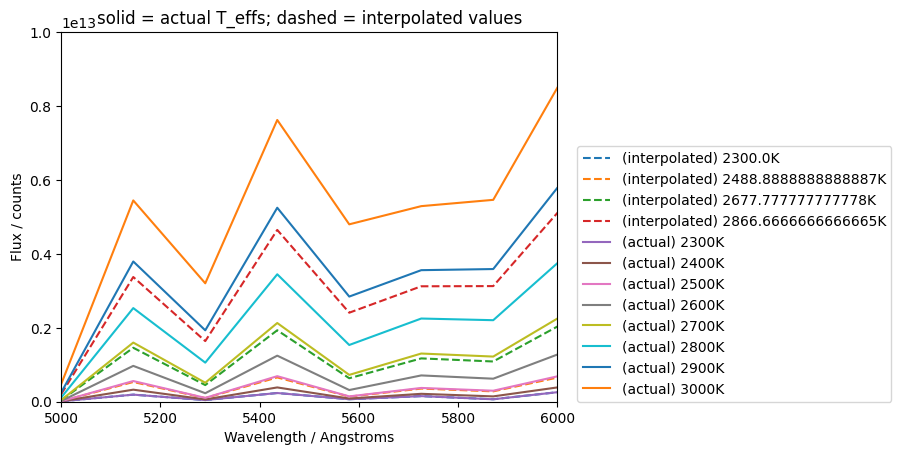

[PHOENIX GRID CREATOR] : writing dataframe to hdf5...
[PHOENIX GRID CREATOR] : hdf5 saving complete


In [36]:

# temperature interpolation
print(df)
REGULARISE_TEMPERATURE_GRID : bool = True
MIN_TEMPERATURE_KELVIN = 2300
MAX_TEMPERATURE_KELVIN = 4000
TEMPERATURE_RESOLUTION_KELVIN = 10
regularised_temperatures = np.linspace(MIN_TEMPERATURE_KELVIN, MAX_TEMPERATURE_KELVIN, TEMPERATURE_RESOLUTION_KELVIN)


if REGULARISE_TEMPERATURE_GRID:
	
	new_df = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WAVELENGTH_COLUMN, FLUX_COLUMN])
	
	for FeH, log_g in tqdm(product(FeHs, log_gs), total= len(FeHs) * len(log_gs), desc="regularising temperature points"):
		
		# this df is at all temperatures
		subset_df = df[(df[FEH_COLUMN] == FeH) & (df[LOGG_COLUMN] == log_g)]
		
		for new_T_eff in regularised_temperatures:
			# aka subset df represents 3D data which maps (wavelength to flux) over a set of temperatures
			# we want the wavelength to flux map at a different temperature; namely at new_T_eff
			
			# so we want to linearly interpolate every flux between T_1 and T_2 at all wavelengths
			# aka. np.interp(new_T_eff, subset_df[TEMPERATURE_COLUMN], subset_df[FLUX_COLUMN]) # assuming this vectorises and returns a map from all wavelengths to fluxes
			
			from scipy.interpolate import interp1d
			
			pivoted = df.pivot(index=TEFF_COLUMN, columns=WAVELENGTH_COLUMN, values=FLUX_COLUMN)
			x = pivoted.index.to_numpy()               # shape (n_temperatures,)
			wavelengths = pivoted.columns.to_numpy()   # shape (n_wavelengths,)
			y = pivoted.values
			
			print(pivoted)
			
			# i think this is the wrong functino to be using: xold seems to determine the dimensionality of the output
			
			f = interp1d(x, y, axis=0)
			
			wavelength_to_flux_map_at_new_T_eff = f(new_T_eff)
			
			temp_df = pd.DataFrame({
				TEFF_COLUMN : new_T_eff,
				FEH_COLUMN : FeH,
				LOGG_COLUMN : log_g,
				WAVELENGTH_COLUMN : wavelengths,
				FLUX_COLUMN : wavelength_to_flux_map_at_new_T_eff # interpolated flux function between previous and next temperatures 
			})
			
			# avoid warning about concat-ing an empty df
			if not new_df.empty:
				# our df index has no meaningful meaning, and sort I think just ensures the columns are in the correct order or something?
				new_df = pd.concat([new_df, temp_df], ignore_index=True)#, sort=True)
			else:
				new_df = temp_df

import matplotlib.pyplot as plt

# new (interpolated) T_effs
debug_min_graph_temperature = 2300
debug_max_graph_temperature = 3000
for T_eff in regularised_temperatures[(debug_min_graph_temperature <= regularised_temperatures) & (regularised_temperatures <= debug_max_graph_temperature)]:
	subset_df = new_df[new_df[TEFF_COLUMN] == T_eff]
	plt.plot(subset_df[WAVELENGTH_COLUMN], subset_df[FLUX_COLUMN], linestyle="dashed", label=f"(interpolated) {T_eff}K")

# old T_effs
for T_eff in T_effs[(debug_min_graph_temperature <= T_effs) & (T_effs <= debug_max_graph_temperature)]:
	subset_df = df[df[TEFF_COLUMN] == T_eff]
	plt.plot(subset_df[WAVELENGTH_COLUMN], subset_df[FLUX_COLUMN], label=f"(actual) {T_eff}K")
plt.title("solid = actual T_effs; dashed = interpolated values")
plt.xlim(5000,6000)
plt.ylim(0,1e13)
plt.xlabel("Wavelength / Angstroms")
plt.ylabel("Flux / counts")
plt.legend(loc=(1.04, 0))
# plt.tight_layout()
plt.show()

# pandas tables can't save their metadata into a HDF5 directly (can use HDFStore or smthn) - but astropy tables can have metadata, units etc. so lets convert to an astropy table
from astropy.table import QTable
table = QTable.from_pandas(new_df)

# add astropy units to columns (this will be stored in metadata and can be read back out into an astropy QTable)
from astropy.units import imperial
imperial.enable()
table[TEFF_COLUMN].unit = u.Kelvin
table[TEFF_COLUMN].desc = "effective surface temperature"

table[FEH_COLUMN].unit = u.dimensionless_unscaled
table[FEH_COLUMN].desc = "relative to solar metallacity"

# astropy seems to have a hard time reading in log quantities from hdf5 files. so lets just save this as unitless
table[LOGG_COLUMN].unit = u.dimensionless_unscaled
table[LOGG_COLUMN].desc = "log_10(u.cm * u.second**(-2)) of the surface gravity"

table[WAVELENGTH_COLUMN].unit = u.Angstrom

table[FLUX_COLUMN].unit = u.dimensionless_unscaled
table[FLUX_COLUMN].desc = "in counts"

# remove the wavelength ranges we don't want

MIN_WAVELENGTH = 0.5 * u.micron
MAX_WAVELENGTH = 15 * u.micron

table = table[(MIN_WAVELENGTH <= table[WAVELENGTH_COLUMN]) & (table[WAVELENGTH_COLUMN] <= MAX_WAVELENGTH)]

import specutils

table[WAVELENGTH_COLUMN] = specutils.utils.wcs_utils.vac_to_air(table[WAVELENGTH_COLUMN])
		

## [SOME INTERPOLATION HERE] ##

# add some metadata to the QTable e.g. (wavelength medium = air, source, date)
import datetime

table.meta = {"wavelength medium" : "air",
			"source" : "https://phoenix.astro.physik.uni-goettingen.de/data/",
			"date this hdf5 file was created" : datetime.datetime.now()}

print("[PHOENIX GRID CREATOR] : writing dataframe to hdf5...")

table.write(HDF5_FILENAME_TO_SAVE, path = "data", serialize_meta=True, overwrite=True)

print("[PHOENIX GRID CREATOR] : hdf5 saving complete")